In [129]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Input


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import LabelEncoder


In [130]:
# (Dans l'autre notebook)
import pandas as pd
df_for_ml = pd.read_csv("./df_for_ml.csv")

In [131]:
df_for_ml["emotion_label"].value_counts()

emotion_label
calm         192
happy        192
sad          192
angry        192
disgust      192
fearful      192
surprised    192
neutral       96
Name: count, dtype: int64

- Séparation en train - Cross Validation - Test set

In [132]:
feature_cols = [c for c in df_for_ml.columns if c.startswith("f_")]
X = df_for_ml[feature_cols].to_numpy(dtype=np.float32)
y = df_for_ml["emotion_label"].to_numpy()

# 75% train, 15% val, 10% test
X_tmp, X_test, y_tmp, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_tmp, y_tmp, test_size=0.15, random_state=42, stratify=y_tmp
)



le = LabelEncoder()
le.fit(y_train)                      # fit sur TRAIN uniquement
y_train_int = le.transform(y_train)
y_val_int   = le.transform(y_val)
y_test_int  = le.transform(y_test)


print(X_train.shape, X_val.shape, X_test.shape)


(1101, 120) (195, 120) (144, 120)


- Centrer réduire les données d'entrainement

In [133]:


# créer l'objet de centrage réduction 
scaler = StandardScaler()                

# Apprendre les paramètres (moyenne/écart-type) sur le TRAIN uniquement
X_train = scaler.fit_transform(X_train).astype(np.float32)

# Réutiliser le MÊME scaler pour centrer/réduire VAL et TEST (pas de fit ici)
X_val   = scaler.transform(X_val).astype(np.float32)
X_test  = scaler.transform(X_test).astype(np.float32)



# Conception des modèles

In [134]:
#Hyperparamètres
input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
LEARNING_RATE = 1e-3
EPOCHS = 100
BATCH_SIZE = 50


In [135]:


def make_mse_onehot(num_classes: int):
    @tf.function
    def mse_onehot(y_true, y_pred):
        # y_true peut être (batch,) ou (batch,1) -> on squeeze et on cast
        y_true = tf.cast(tf.squeeze(y_true), tf.int32)
        y_true_oh = tf.one_hot(y_true, depth=num_classes)
        return tf.reduce_mean(tf.math.squared_difference(y_true_oh, y_pred))
    return mse_onehot


- Hyperparamètres


In [136]:
LEARNING_RATE = 1e-3  # ajuste si besoin
BATCH_SIZE = 64
EPOCHS = 100


In [137]:


LEARNING_RATE = 1e-3

def build_model_A(input_dim: int, num_classes: int,
                  dropout: float = 0.0, lambda_reg: float = 0.0) -> keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    reg = keras.regularizers.l2(lambda_reg)

    x = layers.Dense(32, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer="he_normal")(inputs)
    x = layers.Dropout(dropout)(x)

    probs = layers.Dense(num_classes, activation="softmax", name="softmax_layer")(x)
    model = keras.Model(inputs, probs, name="Model_A")
    model.compile(
        optimizer=keras.optimizers.Adam(LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model


def build_model_B(input_dim: int, num_classes: int,
                  dropout: float = 0.0, lambda_reg: float = 0.0) -> keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    reg = keras.regularizers.l2(lambda_reg)

    x = layers.Dense(64, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer="he_normal")(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(32, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer="he_normal")(x)
    x = layers.Dropout(dropout)(x)

    probs = layers.Dense(num_classes, activation="softmax", name="softmax_layer")(x)
    model = keras.Model(inputs, probs, name="Model_B")
    model.compile(
        optimizer=keras.optimizers.Adam(LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model


def build_model_C(input_dim: int, num_classes: int,
                  dropout: float = 0.0, lambda_reg: float = 0.0) -> keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    reg = keras.regularizers.l2(lambda_reg)
    he_init = keras.initializers.HeNormal()

    x = layers.Dense(100, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer=he_init)(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer=he_init)(x)
    x = layers.Dropout(dropout)(x)

    probs = layers.Dense(num_classes, activation="softmax", name="softmax_layer")(x)
    model = keras.Model(inputs, probs, name="Model_C")
    model.compile(
        optimizer=keras.optimizers.Adam(LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model


def build_model_D(input_dim: int, num_classes: int,
                  dropout: float = 0.0, lambda_reg: float = 0.0) -> keras.Model:
    inputs = layers.Input(shape=(input_dim,))
    reg = keras.regularizers.l2(lambda_reg)

    x = layers.Dense(256, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer="he_normal")(inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(128, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer="he_normal")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu",
                     kernel_regularizer=reg,
                     kernel_initializer="he_normal")(x)
    x = layers.Dropout(dropout)(x)

    probs = layers.Dense(num_classes, activation="softmax", name="softmax_layer")(x)
    model = keras.Model(inputs, probs, name="Model_D")
    model.compile(
        optimizer=keras.optimizers.Adam(LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model


# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=10, min_lr=1e-5),
]

In [138]:

# ==== Instanciation ====
model_A = build_model_A(input_dim, num_classes)
model_B = build_model_B(input_dim, num_classes)
model_C = build_model_C(input_dim, num_classes)
model_D = build_model_D(input_dim, num_classes)


In [145]:

# # ==== Entraînement ====


histories = {}
print("\n=== Entraînement model_A ===")
histories["A"] = model_A.fit(
    X_train, y_train_int, validation_data=(X_val, y_val_int),
    epochs=EPOCHS, batch_size=BATCH_SIZE,  verbose=1
)

print("\n=== Entraînement model_B ===")
histories["B"] = model_B.fit(
    X_train, y_train_int, validation_data=(X_val, y_val_int),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)


print("\n=== Entraînement model_C ===")
histories["C"] = model_C.fit(
    X_train, y_train_int, validation_data=(X_val, y_val_int),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)

print("\n=== Entraînement model_D ===")
histories["D"] = model_D.fit(
    X_train, y_train_int, validation_data=(X_val, y_val_int),
    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1
)


=== Entraînement model_A ===
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9882 - loss: 0.1450 - val_accuracy: 0.6154 - val_loss: 1.3548
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9891 - loss: 0.1417 - val_accuracy: 0.6154 - val_loss: 1.3596
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9891 - loss: 0.1387 - val_accuracy: 0.6154 - val_loss: 1.3631
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9900 - loss: 0.1356 - val_accuracy: 0.6103 - val_loss: 1.3677
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9900 - loss: 0.1328 - val_accuracy: 0.6103 - val_loss: 1.3695
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9909 - loss: 0.1298 - val_accuracy: 0.6103 - val_loss: 1.3768
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9909 - loss: 0.1271 - val_accuracy: 0.6103 - val_loss: 1.3794
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9936 - los

- Evaluation du modèle

In [146]:

# # Ensure integer labels if yours are strings
# def ensure_int(y):
#     y = np.asarray(y)
#     if y.dtype.kind in ("U","S","O"):
#         le = LabelEncoder()
#         y = le.fit_transform(y)
#     return y

# y_train_int = ensure_int(y_train)
# y_val_int   = ensure_int(y_val)

# models = [
#     ("A (peu profond)",  model_A),
#     ("B",                model_B),
#     ("C",                model_C),
#     ("D (plus profond)", model_D),
# ]

# results = []
# for name, model in models:
#     # Predict softmax probabilities, then class ids
#     p_tr = model.predict(X_train, verbose=0)
#     p_va = model.predict(X_val,   verbose=0)
#     yhat_tr = p_tr.argmax(axis=1)
#     yhat_va = p_va.argmax(axis=1)

#     # Accuracy (train/val) and error
#     acc_train = accuracy_score(y_train_int, yhat_tr)
#     acc_val   = accuracy_score(y_val_int,   yhat_va)
#     err_train = 1.0 - acc_train
#     err_val   = 1.0 - acc_valp_tr = model.predict(X_train, verbose=0)
#     p_va = model.predict(X_val,   verbose=0)
#     yhat_tr = p_tr.argmax(axis=1)
#     yhat_va = p_va.argmax(axis=1)

#     # Accuracy (train/val) and error
#     acc_train = accuracy_score(y_train_int, yhat_tr)
#     acc_val   = accuracy_score(y_val_int,   yhat_va)
#     err_train = 1.0 - acc_train
#     err_val   = 1.0 - acc_val

#     # Validation precision/recall/F1 (weighted)
#     prec, rec, f1, _ = precision_recall_fscore_support(
#         y_val_int, yhat_va, average="weighted", zero_division=0
#     )

#     results.append({
#         "model": name,
#         "acc_train": acc_train,
#         "err_train": err_train,
#         "acc_val":   acc_val,
#         "err_val":   err_val,
       
#     })

# summary_df = pd.DataFrame(results).sort_values("acc_val", ascending=False).reset_index(drop=True)
# summary_df


#  Ajustement du modèle C 


In [147]:
model_C_bis = build_model_C(input_dim, num_classes, dropout=0.0, lambda_reg=0.01)

model_C_bis.compile(
        optimizer=keras.optimizers.Adam(LEARNING_RATE),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )

histories = {} 
print("\n=== Entraînement model_C_bis ===")
histories["model_C_bis"] = model_C_bis.fit(
    X_train, y_train_int, validation_data=(X_val, y_val_int),
    callbacks=callbacks, 
    epochs=EPOCHS, batch_size=BATCH_SIZE,  verbose=1
)


=== Entraînement model_C_bis ===
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.1771 - loss: 5.4138 - val_accuracy: 0.2359 - val_loss: 5.0742 - learning_rate: 0.0010
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3297 - loss: 4.7908 - val_accuracy: 0.2974 - val_loss: 4.7383 - learning_rate: 0.0010
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4342 - loss: 4.4026 - val_accuracy: 0.3436 - val_loss: 4.4630 - learning_rate: 0.0010
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5041 - loss: 4.0995 - val_accuracy: 0.3744 - val_loss: 4.2351 - learning_rate: 0.0010
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5577 - loss: 3.8296 - val_accuracy: 0.3949 - val_loss: 4.0260 - learning_rate: 0.0010
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6131 - loss: 3.5859 - val_accuracy: 0.4256 - val_loss: 3.8280 - learning_rate: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

In [148]:
p_tr = model_C_bis.predict(X_train, verbose=0)
p_va = model_C_bis.predict(X_val,   verbose=0)
yhat_tr = p_tr.argmax(axis=1)
yhat_va = p_va.argmax(axis=1)

# Accuracy (train/val) and error
acc_train = accuracy_score(y_train_int, yhat_tr)
acc_val   = accuracy_score(y_val_int,   yhat_va)
err_train = 1.0 - acc_train
err_val   = 1.0 - acc_val


print("Accuracy (train/val): %.2f / %.2f" % (acc_train, acc_val))
print("Error    (train/val): %.2f / %.2f" % (err_train, err_val))

Accuracy (train/val): 1.00 / 0.61
Error    (train/val): 0.00 / 0.39



=== Test dropout=0.00 | lambda_reg=0.0000 ===

=== Test dropout=0.00 | lambda_reg=0.0001 ===

=== Test dropout=0.00 | lambda_reg=0.0010 ===

=== Test dropout=0.00 | lambda_reg=0.0100 ===

=== Test dropout=0.00 | lambda_reg=0.0300 ===

=== Test dropout=0.20 | lambda_reg=0.0000 ===

=== Test dropout=0.20 | lambda_reg=0.0001 ===

=== Test dropout=0.20 | lambda_reg=0.0010 ===

=== Test dropout=0.20 | lambda_reg=0.0100 ===

=== Test dropout=0.20 | lambda_reg=0.0300 ===

=== Test dropout=0.40 | lambda_reg=0.0000 ===

=== Test dropout=0.40 | lambda_reg=0.0001 ===

=== Test dropout=0.40 | lambda_reg=0.0010 ===

=== Test dropout=0.40 | lambda_reg=0.0100 ===

=== Test dropout=0.40 | lambda_reg=0.0300 ===

=== Test dropout=0.60 | lambda_reg=0.0000 ===

=== Test dropout=0.60 | lambda_reg=0.0001 ===

=== Test dropout=0.60 | lambda_reg=0.0010 ===

=== Test dropout=0.60 | lambda_reg=0.0100 ===

=== Test dropout=0.60 | lambda_reg=0.0300 ===

Top 10 (par plus faible erreur validation):
   dropout  lam

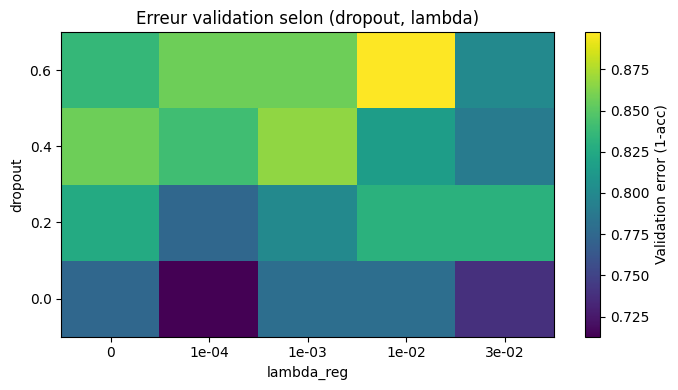

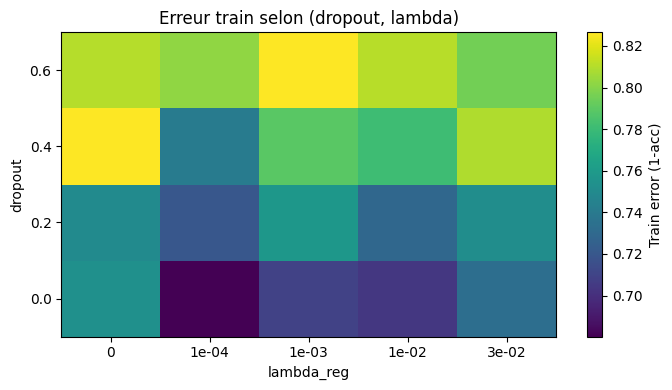

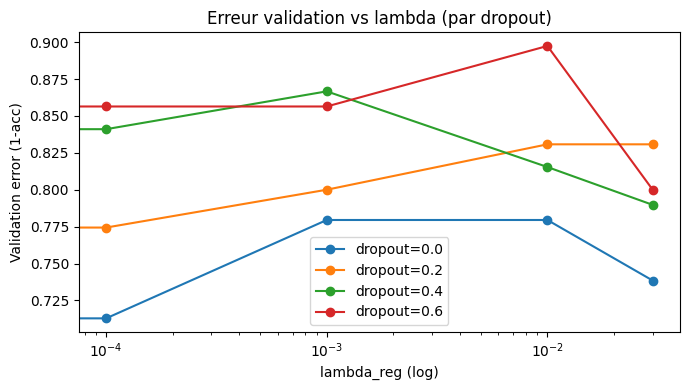

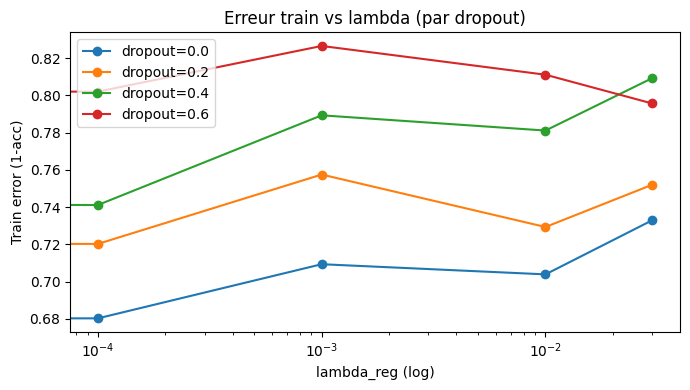

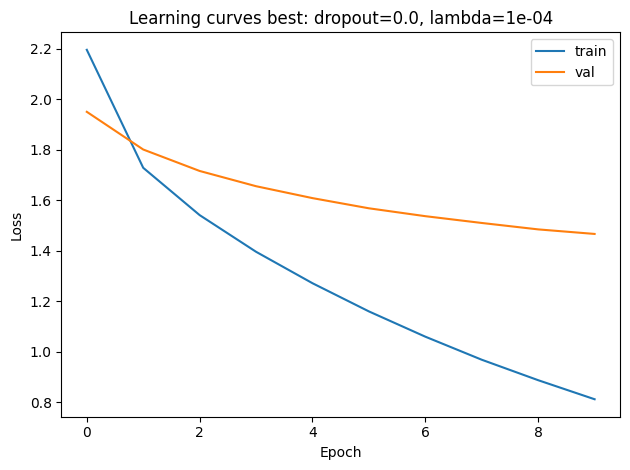

In [149]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from tensorflow import keras
import tensorflow as tf

# Pour la reproductibilité
tf.keras.utils.set_random_seed(42)

# --- Grille d’hyperparamètres ---
dropouts = [0.0, 0.2, 0.4, 0.6]
lambdas  = [0.0, 1e-4, 1e-3, 1e-2, 3e-2]

results = []
histories = {}

for d in dropouts:
    for lam in lambdas:
        print(f"\n=== Test dropout={d:.2f} | lambda_reg={lam:.4f} ===")

        # 1) (Re)construire un modèle neuf à chaque essai
        model = build_model_C(input_dim, num_classes, dropout=d, lambda_reg=lam)
        # Si build_model_C ne compile pas déjà :
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
            loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=["accuracy"],
        )

        # 2) Entraîner
        h = model.fit(
            X_train, y_train_int,
            validation_data=(X_val, y_val_int),
            epochs=EPOCHS, batch_size=BATCH_SIZE,
            callbacks=callbacks, verbose=0
        )
        histories[(d, lam)] = h.history

        # 3) Évaluer (erreurs)
        p_tr = model.predict(X_train, verbose=0)
        p_va = model.predict(X_val,   verbose=0)
        yhat_tr = p_tr.argmax(1)
        yhat_va = p_va.argmax(1)

        acc_train = accuracy_score(y_train_int, yhat_tr)
        acc_val   = accuracy_score(y_val_int,   yhat_va)

        results.append({
            "dropout": d,
            "lambda_reg": lam,
            "acc_train": acc_train,
            "err_train": 1.0 - acc_train,
            "acc_val":   acc_val,
            "err_val":   1.0 - acc_val,
            "best_val_loss": float(np.min(h.history["val_loss"]))
        })

# --- Tableau récapitulatif ---
res_df = pd.DataFrame(results).sort_values("err_val").reset_index(drop=True)
print("\nTop 10 (par plus faible erreur validation):")
print(res_df.head(10))

# === 4) VISU : Heatmaps des erreurs ===
# (a) Heatmap erreur validation
pivot_val = res_df.pivot(index="dropout", columns="lambda_reg", values="err_val").sort_index(ascending=True)
plt.figure(figsize=(7,4))
im = plt.imshow(pivot_val.values, aspect="auto", origin="lower")
plt.xticks(ticks=range(len(pivot_val.columns)), labels=[f"{c:.0e}" if c>0 else "0" for c in pivot_val.columns])
plt.yticks(ticks=range(len(pivot_val.index)),   labels=[f"{r:.1f}" for r in pivot_val.index])
plt.colorbar(im, label="Validation error (1-acc)")
plt.xlabel("lambda_reg"); plt.ylabel("dropout")
plt.title("Erreur validation selon (dropout, lambda)")
plt.tight_layout(); plt.show()

# (b) Heatmap erreur train
pivot_tr = res_df.pivot(index="dropout", columns="lambda_reg", values="err_train").sort_index(ascending=True)
plt.figure(figsize=(7,4))
im = plt.imshow(pivot_tr.values, aspect="auto", origin="lower")
plt.xticks(ticks=range(len(pivot_tr.columns)), labels=[f"{c:.0e}" if c>0 else "0" for c in pivot_tr.columns])
plt.yticks(ticks=range(len(pivot_tr.index)),   labels=[f"{r:.1f}" for r in pivot_tr.index])
plt.colorbar(im, label="Train error (1-acc)")
plt.xlabel("lambda_reg"); plt.ylabel("dropout")
plt.title("Erreur train selon (dropout, lambda)")
plt.tight_layout(); plt.show()

# === 5) VISU : Courbes erreur vs lambda pour chaque dropout ===
plt.figure(figsize=(7,4))
for d in dropouts:
    sub = res_df[res_df["dropout"]==d].sort_values("lambda_reg")
    plt.plot(sub["lambda_reg"], sub["err_val"], marker="o", label=f"dropout={d}")
plt.xscale("log"); plt.xlabel("lambda_reg (log)")
plt.ylabel("Validation error (1-acc)")
plt.title("Erreur validation vs lambda (par dropout)")
plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(7,4))
for d in dropouts:
    sub = res_df[res_df["dropout"]==d].sort_values("lambda_reg")
    plt.plot(sub["lambda_reg"], sub["err_train"], marker="o", label=f"dropout={d}")
plt.xscale("log"); plt.xlabel("lambda_reg (log)")
plt.ylabel("Train error (1-acc)")
plt.title("Erreur train vs lambda (par dropout)")
plt.legend(); plt.tight_layout(); plt.show()

# === 6) (Optionnel) Learning curves pour le meilleur couple ===
best = res_df.iloc[0]
best_hist = histories[(best["dropout"], best["lambda_reg"])]
plt.figure()
plt.plot(best_hist["loss"], label="train")
plt.plot(best_hist["val_loss"], label="val")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(
    f"Learning curves best: dropout={best['dropout']}, lambda={best['lambda_reg']:.0e}")
plt.legend(); plt.tight_layout(); plt.show()
